In [2]:
!nvidia-smi

Tue Oct 14 18:18:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip -q install --upgrade pip
!pip -q install opencv-python pillow matplotlib albumentations tqdm einops

# (Colab ships with torch/torchvision; uncomment if you need a specific CUDA build)
# !pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121

# Clone official MODNet
%cd /content
!git clone https://github.com/ZHKKKe/MODNet.git
%cd MODNet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 77.1 MB/s eta 0:00:00
/content
Cloning into 'MODNet'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 276 (delta 21), reused 16 (delta 16), pack-reused 236 (from 1)
Receiving objects: 100% (276/276), 60.77 MiB | 11.43 MiB/s, done.
Resolving deltas: 100% (100/100), done.
/content/MODNet


In [27]:
import os, sys, glob, math, random, time
from pathlib import Path
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image




device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
import shutil
import random
from pathlib import Path

# === Paths ===
AIM_ROOT = Path('/content/drive/MyDrive/AIM')
DATA_ROOT = Path('/content/drive/MyDrive/modnet_data')

original_dir = AIM_ROOT / 'original'
mask_dir = AIM_ROOT / 'mask'

train_img_dir = DATA_ROOT / 'train' / 'images'
train_matte_dir = DATA_ROOT / 'train' / 'mattes'
val_img_dir = DATA_ROOT / 'val' / 'images'
val_matte_dir = DATA_ROOT / 'val' / 'mattes'
test_img_dir = DATA_ROOT / 'test' / 'images'
test_matte_dir = DATA_ROOT / 'test' / 'mattes'

# === Create folders ===
for d in [train_img_dir, train_matte_dir, val_img_dir, val_matte_dir, test_img_dir, test_matte_dir]:
    d.mkdir(parents=True, exist_ok=True)

# === Parameters ===
split_ratio = (0.8, 0.1, 0.1)
valid_exts = {'.jpg', '.jpeg', '.png'}

# === Collect base filenames from original ===
original_files = [f for f in os.listdir(original_dir) if Path(f).suffix.lower() in valid_exts]
base_names = [Path(f).stem for f in original_files]
random.shuffle(base_names)

n_total = len(base_names)
n_train = int(n_total * split_ratio[0])
n_val = int(n_total * split_ratio[1])
train_bases = base_names[:n_train]
val_bases = base_names[n_train:n_train+n_val]
test_bases = base_names[n_train+n_val:]

def find_file_by_stem(folder, stem):
    """Return the first file in folder that matches the given stem (any extension)."""
    matches = list(folder.glob(stem + '.*'))
    return matches[0] if matches else None

def copy_pairs(basenames, img_dst, matte_dst):
    i=0
    for stem in basenames:
        src_img = find_file_by_stem(original_dir, stem)
        src_mask = find_file_by_stem(mask_dir, stem)
        if src_img and src_mask:
            i++
            shutil.copy2(src_img, img_dst / src_img.name)
            shutil.copy2(src_mask, matte_dst / src_mask.name)
            print(str(i)+"\t"+src_img.name+" copied successfully!")
        else:
            print(f"⚠️ Skipped {stem} (missing pair)")

# === Copy all ===
print(f"📦 Total images: {n_total}")
print(f"➡️ Train: {len(train_bases)}, Val: {len(val_bases)}, Test: {len(test_bases)}")

copy_pairs(train_bases, train_img_dir, train_matte_dir)
copy_pairs(val_bases, val_img_dir, val_matte_dir)
copy_pairs(test_bases, test_img_dir, test_matte_dir)





📦 Total images: 500
➡️ Train: 400, Val: 50, Test: 50
o_2941a07a.jpgcopied successfully!
o_bab88684.jpgcopied successfully!
o_099cc48f.jpgcopied successfully!
o_3a9a5e7c.jpgcopied successfully!
o_e4f47cba.jpgcopied successfully!
o_d2a1bff3.jpgcopied successfully!
o_1467861e.jpgcopied successfully!
o_494867da.jpgcopied successfully!
o_f95689c1.jpgcopied successfully!
o_684f0dfb.jpgcopied successfully!
o_a9d87400.jpgcopied successfully!
o_380bb319.jpgcopied successfully!
o_7f008485.jpgcopied successfully!
o_52a2115b.jpgcopied successfully!
o_8861e554.jpgcopied successfully!
o_8e2eb72f.jpgcopied successfully!
o_418d6d35.jpgcopied successfully!
o_d8b96fe7.jpgcopied successfully!
o_6b15071e.jpgcopied successfully!
o_3715959a.jpgcopied successfully!
o_b085e7dc.jpgcopied successfully!
o_507a9a58.jpgcopied successfully!
o_b2dfc20d.jpgcopied successfully!
o_8c31f783.jpgcopied successfully!
o_f82f042a.jpgcopied successfully!
o_1f05f13c.jpgcopied successfully!
o_868c53f0.jpgcopied successfully!
o_

In [24]:
import os, sys, importlib.util, types

# Path where you cloned the repo
repo_root = "/content/MODNet"
modnet_file = os.path.join(repo_root, "src", "models", "modnet.py")
backbones_file = os.path.join(repo_root, "src", "models", "backbones", "__init__.py")

# Create stub packages so relative imports in modnet.py work
pkg_src = types.ModuleType("src"); pkg_src.__path__ = [os.path.join(repo_root, "src")]
pkg_models = types.ModuleType("src.models"); pkg_models.__path__ = [os.path.join(repo_root, "src", "models")]
sys.modules["src"] = pkg_src
sys.modules["src.models"] = pkg_models

# Load backbones first
spec_bk = importlib.util.spec_from_file_location("src.models.backbones", backbones_file)
bk_mod = importlib.util.module_from_spec(spec_bk)
sys.modules["src.models.backbones"] = bk_mod
spec_bk.loader.exec_module(bk_mod)

# Load modnet
spec_md = importlib.util.spec_from_file_location("src.models.modnet", modnet_file)
modnet_mod = importlib.util.module_from_spec(spec_md)
sys.modules["src.models.modnet"] = modnet_mod
spec_md.loader.exec_module(modnet_mod)

# Get class
MODNet = modnet_mod.MODNet
print("✅ MODNet class loaded:", MODNet)

✅ MODNet class loaded: <class 'src.models.modnet.MODNet'>


In [25]:
!mkdir -p /content/MODNet/pretrained
!wget -q https://github.com/ZHKKKe/MODNet/releases/download/v1/modnet_webcam_portrait_matting.ckpt \
    -O /content/MODNet/pretrained/modnet_webcam_portrait_matting.ckpt


In [33]:
# =====================================================
#  🧩 Updated PortraitDataset (Fix Normalize Issue)
# =====================================================
class PortraitDataset(Dataset):
    def __init__(self, img_dir, matte_dir, img_transform=None, matte_transform=None):
        self.img_dir = Path(img_dir)
        self.matte_dir = Path(matte_dir)
        self.img_transform = img_transform
        self.matte_transform = matte_transform

        img_stems = {p.stem for p in self.img_dir.glob('*')}
        matte_stems = {p.stem for p in self.matte_dir.glob('*')}
        self.common_stems = sorted(list(img_stems & matte_stems))
        print(f"✅ Found {len(self.common_stems)} paired samples in {self.img_dir.parent.name}")

    def __len__(self):
        return len(self.common_stems)

    def __getitem__(self, idx):
      stem = self.common_stems[idx]
      img_path = list(self.img_dir.glob(stem + '.*'))[0]
      matte_path = list(self.matte_dir.glob(stem + '.*'))[0]

      image = Image.open(img_path).convert("RGB")
      matte = Image.open(matte_path).convert("L")

      if self.img_transform:
          image = self.img_transform(image)
      if self.matte_transform:
          matte = self.matte_transform(matte)

      return image, matte


In [45]:
import torchvision.transforms as T

transform_img = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])

transform_matte = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])

In [46]:
# =====================================================
#  🧩 Part 2 — Dataloaders and Transforms
# =====================================================
from torch.utils.data import DataLoader
from torchvision import transforms

# --- Image preprocessing ---
# Resize all samples to 512×512 (MODNet input size) and convert to tensors
# Normalization is optional here; MODNet uses range [-1, 1] internally.
transform_train = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

transform_val = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# --- Create Dataset instances ---
train_ds = PortraitDataset(
    train_img_dir,
    train_matte_dir,
    img_transform=transform_train,
    # matte_transform=transform_matte_train  # optional
    matte_transform=transform_matte
)

val_ds = PortraitDataset(
    val_img_dir,
    val_matte_dir,
    img_transform=transform_val,
    # matte_transform=transform_matte_val  # optional
    matte_transform=transform_matte
)

# --- DataLoaders ---
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ Train set: {len(train_ds)} samples, Val set: {len(val_ds)} samples")


✅ Found 400 paired samples in train
✅ Found 50 paired samples in val
✅ Train set: 400 samples, Val set: 50 samples


In [36]:
# =====================================================
#  🧩 Part 3 — Load Pretrained MODNet Model
# =====================================================
import torch
from pathlib import Path
import sys

# # --- Device setup ---
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"🧠 Using device: {device}")

# # --- Add MODNet source path ---
# # Make sure you cloned MODNet official repo or have the source in your environment.
# MODNET_PATH = Path('/content/MODNet/src')  # adjust if needed
# if not MODNET_PATH.exists():
#     raise FileNotFoundError("❌ MODNet source path not found! Please clone it into /content/MODNet")

# if str(MODNET_PATH) not in sys.path:
#     sys.path.append(str(MODNET_PATH))

# --- Import the model class ---
# from models.modnet import MODNet

# --- Initialize model ---
model = MODNet(backbone_pretrained=False).to(device)

# --- Load pretrained checkpoint ---
pretrained_model_name ='modnet_webcam_portrait_matting.ckpt'
PRETRAINED_CKPT = Path('/content/drive/MyDrive/modnet_data/pretrained/'+pretrained_model_name)
print(f"📂 Loading pretrained weights from: {PRETRAINED_CKPT}")

state = torch.load(PRETRAINED_CKPT, map_location=device)

# handle different checkpoint formats
if isinstance(state, dict) and 'state_dict' in state:
    state = state['state_dict']
state = {k.replace('module.', ''): v for k, v in state.items()}

missing, unexpected = model.load_state_dict(state, strict=False)
print(f"✅ Model loaded. Missing: {len(missing)} | Unexpected: {len(unexpected)}")

# --- Set to training mode ---
model.train()


🧠 Using device: cuda
📂 Loading pretrained weights from: /content/drive/MyDrive/modnet_data/pretrained/modnet_webcam_portrait_matting.ckpt
✅ Model loaded. Missing: 0 | Unexpected: 0


MODNet(
  (backbone): MobileNetV2Backbone(
    (model): MobileNetV2(
      (features): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
            (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
     

In [37]:
# =====================================================
#  🧩 Part 4 — Define Loss Function and Optimizer
# =====================================================
import torch.nn.functional as F

# --- Loss Function ---
# MODNet predicts the alpha matte, so we use L1 (absolute error) loss
# You can combine with L2 or add edge loss later for refinement.
def matte_loss(pred, target):
    """Compute L1 loss between predicted and ground-truth matte."""
    return F.l1_loss(pred, target)

# --- Optimizer ---
# AdamW is preferred for stability; fine-tuning usually needs a small LR
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-5,         # lower learning rate for fine-tuning
    weight_decay=1e-4
)

# --- Optional: Learning Rate Scheduler ---
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print("✅ Optimizer and loss function are ready.")


✅ Optimizer and loss function are ready.


In [43]:
print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Train loader size: {len(train_loader)}")
print(f"Validation loader size: {len(val_loader)}")

Train dataset size: 400
Validation dataset size: 50
Train loader size: 100
Validation loader size: 25


In [47]:
# =====================================================
#  🧩 Part 5 — Training Loop and Validation
# =====================================================
from tqdm import tqdm
import torch

EPOCHS = 10  # you can increase to 30–50 if you have enough data

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    # --- Training phase ---
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}] Training")
    for imgs, mattes in loop:
        imgs, mattes = imgs.to(device), mattes.to(device)

        optimizer.zero_grad()

        # Forward pass
        _, _, pred_mattes = model(imgs, True)

        # Compute loss
        loss = matte_loss(pred_mattes, mattes)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    print(f"📉 Average Training Loss: {avg_train_loss:.6f}")

    # --- Validation phase ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, mattes in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}] Validation"):
            imgs, mattes = imgs.to(device), mattes.to(device)
            _, _, pred_mattes = model(imgs, True)
            loss = matte_loss(pred_mattes, mattes)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"✅ Validation Loss: {avg_val_loss:.6f}")

    # --- Update LR scheduler ---
    scheduler.step()

print("🎉 Training completed successfully!")


Epoch [1/10] Training: 100%|██████████| 100/100 [00:38<00:00,  2.61it/s, loss=0.0944]


📉 Average Training Loss: 0.063023


Epoch [1/10] Validation: 100%|██████████| 25/25 [00:02<00:00,  8.49it/s]


✅ Validation Loss: 0.060080


Epoch [2/10] Training: 100%|██████████| 100/100 [00:37<00:00,  2.66it/s, loss=0.0507]


📉 Average Training Loss: 0.043193


Epoch [2/10] Validation: 100%|██████████| 25/25 [00:02<00:00,  8.78it/s]


✅ Validation Loss: 0.046811


Epoch [3/10] Training: 100%|██████████| 100/100 [00:36<00:00,  2.74it/s, loss=0.0512]


📉 Average Training Loss: 0.038946


Epoch [3/10] Validation: 100%|██████████| 25/25 [00:02<00:00,  8.39it/s]


✅ Validation Loss: 0.042975


Epoch [4/10] Training: 100%|██████████| 100/100 [00:37<00:00,  2.64it/s, loss=0.0268]


📉 Average Training Loss: 0.033936


Epoch [4/10] Validation: 100%|██████████| 25/25 [00:02<00:00,  8.60it/s]


✅ Validation Loss: 0.041148


Epoch [5/10] Training: 100%|██████████| 100/100 [00:34<00:00,  2.87it/s, loss=0.0546]


📉 Average Training Loss: 0.031354


Epoch [5/10] Validation: 100%|██████████| 25/25 [00:04<00:00,  5.58it/s]


✅ Validation Loss: 0.036648


Epoch [6/10] Training: 100%|██████████| 100/100 [00:35<00:00,  2.83it/s, loss=0.0118]


📉 Average Training Loss: 0.028316


Epoch [6/10] Validation: 100%|██████████| 25/25 [00:03<00:00,  7.92it/s]


✅ Validation Loss: 0.035503


Epoch [7/10] Training: 100%|██████████| 100/100 [00:37<00:00,  2.65it/s, loss=0.00934]


📉 Average Training Loss: 0.029206


Epoch [7/10] Validation: 100%|██████████| 25/25 [00:03<00:00,  8.16it/s]


✅ Validation Loss: 0.035658


Epoch [8/10] Training: 100%|██████████| 100/100 [00:36<00:00,  2.75it/s, loss=0.0753]


📉 Average Training Loss: 0.028190


Epoch [8/10] Validation: 100%|██████████| 25/25 [00:02<00:00,  8.68it/s]


✅ Validation Loss: 0.036464


Epoch [9/10] Training: 100%|██████████| 100/100 [00:36<00:00,  2.71it/s, loss=0.00868]


📉 Average Training Loss: 0.028093


Epoch [9/10] Validation: 100%|██████████| 25/25 [00:02<00:00,  8.57it/s]


✅ Validation Loss: 0.033017


Epoch [10/10] Training: 100%|██████████| 100/100 [00:38<00:00,  2.60it/s, loss=0.0331]


📉 Average Training Loss: 0.025622


Epoch [10/10] Validation: 100%|██████████| 25/25 [00:02<00:00,  8.63it/s]

✅ Validation Loss: 0.033546
🎉 Training completed successfully!


In [48]:
# =====================================================
#  🧩 Part 6 — Evaluate Model Accuracy / Quality
# =====================================================
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

def evaluate_model(model, loader):
    model.eval()
    mae_total, mse_total, iou_total = 0, 0, 0
    n = 0

    with torch.no_grad():
        for imgs, mattes in tqdm(loader, desc="Evaluating"):
            imgs, mattes = imgs.to(device), mattes.to(device)
            _, _, pred_mattes = model(imgs, True)
            pred_mattes = torch.clamp(pred_mattes, 0, 1)

            # --- MAE & MSE ---
            mae = F.l1_loss(pred_mattes, mattes, reduction='mean')
            mse = F.mse_loss(pred_mattes, mattes, reduction='mean')

            # --- IoU (binary) ---
            pred_bin = (pred_mattes > 0.5).float()
            target_bin = (mattes > 0.5).float()
            intersection = (pred_bin * target_bin).sum()
            union = (pred_bin + target_bin - pred_bin * target_bin).sum()
            iou = intersection / (union + 1e-6)

            mae_total += mae.item()
            mse_total += mse.item()
            iou_total += iou.item()
            n += 1

    print(f"📊 Validation Metrics:")
    print(f"   • MAE: {mae_total/n:.6f}")
    print(f"   • MSE: {mse_total/n:.6f}")
    print(f"   • IoU: {iou_total/n:.6f}")
    return mae_total/n, mse_total/n, iou_total/n

# Example: run after training
mae, mse, iou = evaluate_model(model, val_loader)


Evaluating: 100%|██████████| 25/25 [00:03<00:00,  8.11it/s]

📊 Validation Metrics:
   • MAE: 0.033546
   • MSE: 0.024328
   • IoU: 0.886650


Epoch [1/10] Validation: 100%|██████████| 25/25 [00:04<00:00,  5.76it/s]



📊 Epoch 1/10 Summary:
   Train Loss: 0.027270
   Val Loss:   0.032347
   MAE: 0.032347 | MSE: 0.023276 | IoU: 0.889025


Epoch [2/10] Validation: 100%|██████████| 25/25 [00:04<00:00,  5.04it/s]



📊 Epoch 2/10 Summary:
   Train Loss: 0.025318
   Val Loss:   0.031458
   MAE: 0.031458 | MSE: 0.022363 | IoU: 0.892074


Epoch [3/10] Validation: 100%|██████████| 25/25 [00:02<00:00,  8.63it/s]



📊 Epoch 3/10 Summary:
   Train Loss: 0.025614
   Val Loss:   0.029654
   MAE: 0.029654 | MSE: 0.020940 | IoU: 0.899985


Epoch [4/10] Validation: 100%|██████████| 25/25 [00:02<00:00,  8.64it/s]



📊 Epoch 4/10 Summary:
   Train Loss: 0.024335
   Val Loss:   0.033054
   MAE: 0.033054 | MSE: 0.024224 | IoU: 0.888575


Epoch [5/10] Validation: 100%|██████████| 25/25 [00:02<00:00,  8.73it/s]



📊 Epoch 5/10 Summary:
   Train Loss: 0.025213
   Val Loss:   0.028207
   MAE: 0.028207 | MSE: 0.019246 | IoU: 0.901340


Epoch [6/10] Validation: 100%|██████████| 25/25 [00:03<00:00,  7.48it/s]



📊 Epoch 6/10 Summary:
   Train Loss: 0.025062
   Val Loss:   0.031939
   MAE: 0.031939 | MSE: 0.022947 | IoU: 0.890120


Epoch [7/10] Validation: 100%|██████████| 25/25 [00:04<00:00,  5.58it/s]



📊 Epoch 7/10 Summary:
   Train Loss: 0.024973
   Val Loss:   0.030595
   MAE: 0.030595 | MSE: 0.021620 | IoU: 0.894101


Epoch [8/10] Validation: 100%|██████████| 25/25 [00:04<00:00,  5.63it/s]



📊 Epoch 8/10 Summary:
   Train Loss: 0.025691
   Val Loss:   0.030804
   MAE: 0.030804 | MSE: 0.021947 | IoU: 0.896642


Epoch [9/10] Validation: 100%|██████████| 25/25 [00:03<00:00,  7.47it/s]



📊 Epoch 9/10 Summary:
   Train Loss: 0.024124
   Val Loss:   0.032452
   MAE: 0.032452 | MSE: 0.023448 | IoU: 0.890181


Epoch [10/10] Validation: 100%|██████████| 25/25 [00:02<00:00,  8.45it/s]



📊 Epoch 10/10 Summary:
   Train Loss: 0.024091
   Val Loss:   0.027896
   MAE: 0.027896 | MSE: 0.019178 | IoU: 0.902338


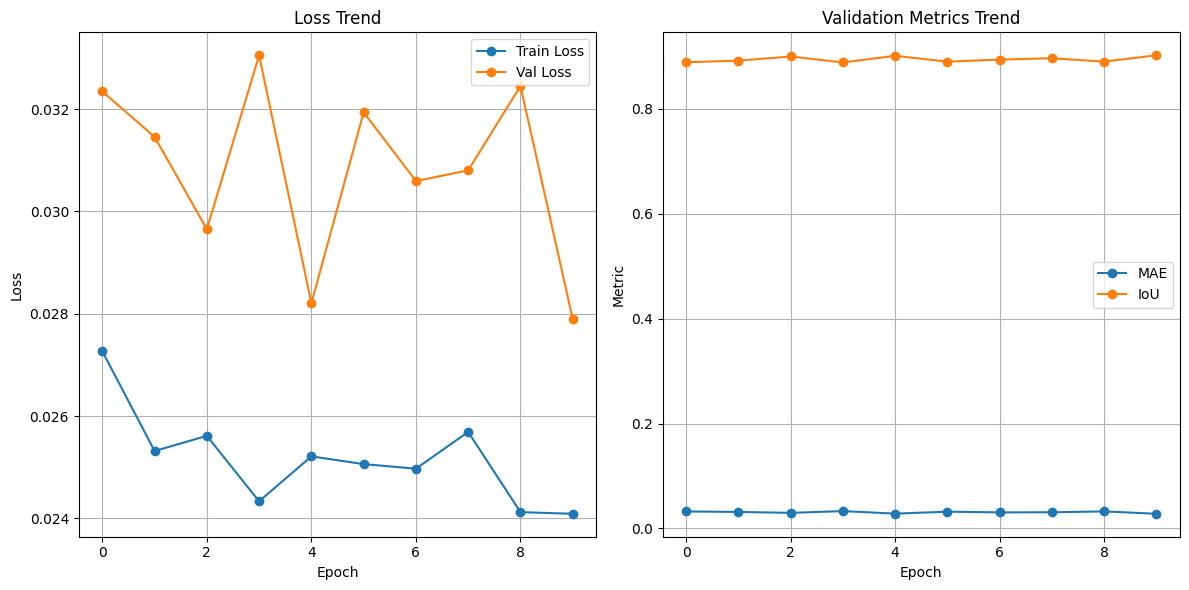

In [49]:
# =====================================================
#  🧩 Part 7 — Training with Metric Logging + Plot
# =====================================================
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

EPOCHS = 10

# Storage lists
train_losses, val_losses, mae_list, mse_list, iou_list = [], [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}] Training")
    for imgs, mattes in loop:
        imgs, mattes = imgs.to(device), mattes.to(device)
        optimizer.zero_grad()

        _, _, pred_mattes = model(imgs, True)
        loss = matte_loss(pred_mattes, mattes)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    mae_total, mse_total, iou_total, n = 0, 0, 0, 0

    with torch.no_grad():
        for imgs, mattes in tqdm(val_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}] Validation"):
            imgs, mattes = imgs.to(device), mattes.to(device)
            _, _, preds = model(imgs, True)
            preds = torch.clamp(preds, 0, 1)

            loss = matte_loss(preds, mattes)
            val_loss += loss.item()

            # Metrics
            mae = F.l1_loss(preds, mattes)
            mse = F.mse_loss(preds, mattes)
            pred_bin = (preds > 0.5).float()
            target_bin = (mattes > 0.5).float()
            intersection = (pred_bin * target_bin).sum()
            union = (pred_bin + target_bin - pred_bin * target_bin).sum()
            iou = intersection / (union + 1e-6)

            mae_total += mae.item()
            mse_total += mse.item()
            iou_total += iou.item()
            n += 1

    avg_val_loss = val_loss / len(val_loader)
    avg_mae, avg_mse, avg_iou = mae_total/n, mse_total/n, iou_total/n

    val_losses.append(avg_val_loss)
    mae_list.append(avg_mae)
    mse_list.append(avg_mse)
    iou_list.append(avg_iou)

    print(f"\n📊 Epoch {epoch+1}/{EPOCHS} Summary:")
    print(f"   Train Loss: {avg_train_loss:.6f}")
    print(f"   Val Loss:   {avg_val_loss:.6f}")
    print(f"   MAE: {avg_mae:.6f} | MSE: {avg_mse:.6f} | IoU: {avg_iou:.6f}")

    scheduler.step()

# =====================================================
#  📈 Plotting Trends
# =====================================================
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('Loss Trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(mae_list, label='MAE', marker='o')
plt.plot(iou_list, label='IoU', marker='o')
plt.title('Validation Metrics Trend')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [50]:
# =====================================================
#  🧩 Part 8 — Save Model and Plots to Google Drive
# =====================================================
import os
from pathlib import Path
import matplotlib.pyplot as plt

# --- Target directory ---
SAVE_DIR = Path('/content/drive/MyDrive/modnet_runs')
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# --- 1. Save fine-tuned model ---
MODEL_PATH = SAVE_DIR / 'modnet_finetuned.ckpt'
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved to: {MODEL_PATH}")

# --- 2. Save training plots ---
PLOT_PATH = SAVE_DIR / 'training_trends.png'

plt.figure(figsize=(12,6))

# Loss trend
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title('Loss Trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Validation metrics
plt.subplot(1,2,2)
plt.plot(mae_list, label='MAE', marker='o')
plt.plot(iou_list, label='IoU', marker='o')
plt.title('Validation Metrics Trend')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(PLOT_PATH, dpi=200)
plt.close()
print(f"✅ Training plots saved to: {PLOT_PATH}")


✅ Model saved to: /content/drive/MyDrive/modnet_runs/modnet_finetuned.ckpt
✅ Training plots saved to: /content/drive/MyDrive/modnet_runs/training_trends.png
